# Lab 11: Text Processing


Today’s data contains excerpts from high-profile criminal trials.
Already cleaned and formatted into a CSV.

[Data Description](http://web.eecs.umich.edu/~mihalcea/papers/perezrosas.icmi15.pdf)
[Download Page](https://lit.eecs.umich.edu/deceptiondetection/)

# Warm-Up Exercise
First, we will go through a simple practice exercise in class. See the course
Github page after class for the completed code if you were not able to attend.

# Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Load data


In [2]:
trial_data = pd.read_csv('data/trial_data.csv')

# Word Counts
One of the simplest forms of text analysis is to count words. Counting words, however, can be performed many ways.
You could use the `.str.split().str.len()` method from the warm-up. We can also use the NLTK *tokenizer*, 
which breaks down a string into tokens (usually words). 

First, let's us an example from [StackOverflow](https://stackoverflow.com/questions/10677020/).


In [3]:
"""
If the code below gives you a LookupError, you will need to download an extra NLTK library. 
To this, just run the following two lines. You only need to do this ONCE!

import nltk
nltk.download('punkt')

"""

from nltk.tokenize import word_tokenize

text = "This is my text. It includes commas, question marks? and other stuff. Acronyms, like U.S. or Dr. aren't easy to handle."
tokens = word_tokenize(text)
print(tokens)

['This', 'is', 'my', 'text', '.', 'It', 'includes', 'commas', ',', 'question', 'marks', '?', 'and', 'other', 'stuff', '.', 'Acronyms', ',', 'like', 'U.S.', 'or', 'Dr.', 'are', "n't", 'easy', 'to', 'handle', '.']


Explore the output of this command. What do you notice?

For our dataset, we just need to apply this function to the text column. We will do this with `.apply()`. 

In [4]:
trial_data['tokens'] = trial_data['transcript'].apply(word_tokenize)

Next, remove the punctuation tokens. We will do/have done this in the warmup exercise.

In [5]:
import string
trial_data['words_only'] = trial_data['tokens'].apply(lambda x: [word for word in x if word not in string.punctuation])

Look at this dataframe. It now has a column where each row contains a list of words. 
Next, apply `len` to the `'words'` column to get the total word count for each row. `len` 
counts the number of elements in a list.

If you compare the results from this method to word counts using the technique from the warmup, you will notice
slight differences. This is common in text analysis. There are many ways that people count words, and it
depends on how people handle punctuation, abbreviation, and acronyms.

<AxesSubplot:>

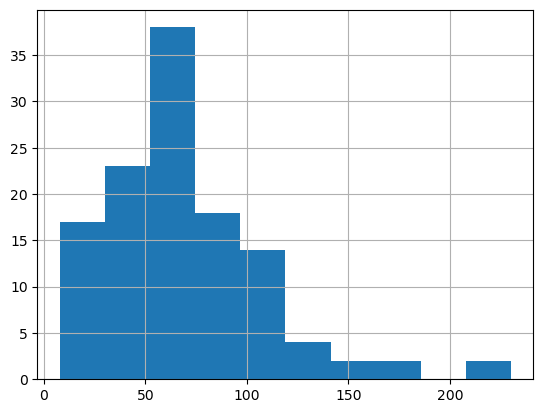

In [6]:
trial_data['word_count_nltk'] = trial_data['words_only'].apply(len)
trial_data['word_count_nltk'].hist()

# Sentiment
Sentiment analysis is extremely common in text analytics. The goal of sentiment analysis
is to determine how positive or negative (or neutral) a passage of text is. Like word counting,
there are many ways to do this. We will use the most popular method today, 
[VADER](https://github.com/cjhutto/vaderSentiment).

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk_sentiment = SentimentIntensityAnalyzer()

## Get polarity scores
Polarity scores are positve, negative, neutral, and compound (aka overall sentiment). These
dimensions are important, since a sentence can have both positive and negative affect.

In [8]:
full_sent = trial_data['transcript'].apply(lambda x: nltk_sentiment.polarity_scores(x))
full_sent.head()

0    {'neg': 0.398, 'neu': 0.602, 'pos': 0.0, 'comp...
1    {'neg': 0.012, 'neu': 0.965, 'pos': 0.024, 'co...
2    {'neg': 0.268, 'neu': 0.732, 'pos': 0.0, 'comp...
3    {'neg': 0.154, 'neu': 0.8, 'pos': 0.046, 'comp...
4    {'neg': 0.145, 'neu': 0.749, 'pos': 0.106, 'co...
Name: transcript, dtype: object

In [9]:
# store the compound sentiment in a column
trial_data['sentiment'] = full_sent.apply(lambda x: x['compound'])
print(trial_data['sentiment'].head())

0   -0.6808
1    0.3612
2   -0.2960
3   -0.6964
4   -0.8829
Name: sentiment, dtype: float64


## View the distribution of sentiment

<AxesSubplot:>

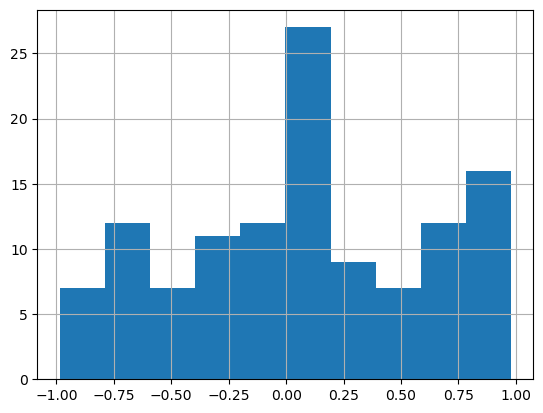

In [10]:
trial_data['sentiment'].hist()

# Predictive Analysis
Let's see if we can predict when someone is lying vs. telling the truth (`outcome`) using the quantity of words and 
the sentement of their statements (`pred_vars`).

In [11]:
pred_vars = ['word_count_nltk', 'sentiment']

# define the dependent variable here, so we don't have to edit our later code
outcome = 'condition'

## Data Preparation
We are going to follow the same steps for classification that we have covered all semester. Much of this
code is copy/paste from previous weeks (with minor changes).

The steps are:
1. Train/test split
2. Fit several classifiers (using cross validation & parameter searching)
3. Evaluate models on hold-out data (aka test data)
4. Report Results

### 1. Train/test split

In [12]:
from sklearn.model_selection import GroupShuffleSplit 
# https://stackoverflow.com/questions/54797508/how-to-generate-a-train-test-split-based-on-a-group-id

splitter = GroupShuffleSplit(test_size=.20, n_splits=2)
split = splitter.split(trial_data, groups=trial_data['name'])
train_inds, test_inds = next(split)

train = trial_data.iloc[train_inds]
test = trial_data.iloc[test_inds]
print("Rows in train:", len(train))
print("Rows in test:", len(test))

Rows in train: 101
Rows in test: 19


### 2. Fit Classifiers

In [13]:
#%% random forest
from sklearn.ensemble import RandomForestClassifier

params = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, None]}

rf_tuned = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='roc_auc')
rf_tuned.fit(train[pred_vars], train[outcome])


#%% Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier

params = {'hidden_layer_sizes': [(100,), (10,10), (5,5,5)], 
          'solver': ['adam', 'lbfgs', 'sgd']}

nnet_tuned = GridSearchCV(MLPClassifier(), param_grid=params, scoring='roc_auc')
nnet_tuned.fit(train[pred_vars], train[outcome])

#%% adaboost
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

from sklearn.ensemble import AdaBoostClassifier

params = {'n_estimators': [10, 25, 50]}

ada_tuned = GridSearchCV(AdaBoostClassifier(), param_grid=params, scoring='roc_auc')
ada_tuned.fit(train[pred_vars], train[outcome])

C:\Users\lee\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
C:\Users\lee\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
C:\Users\lee\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [10, 25, 50]}, scoring='roc_auc')

### 3. Evaluate with Hold-Out Data

This code is copied from previous labs.

RandomForestClassifier()
MLPClassifier()
AdaBoostClassifier()


C:\Users\lee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


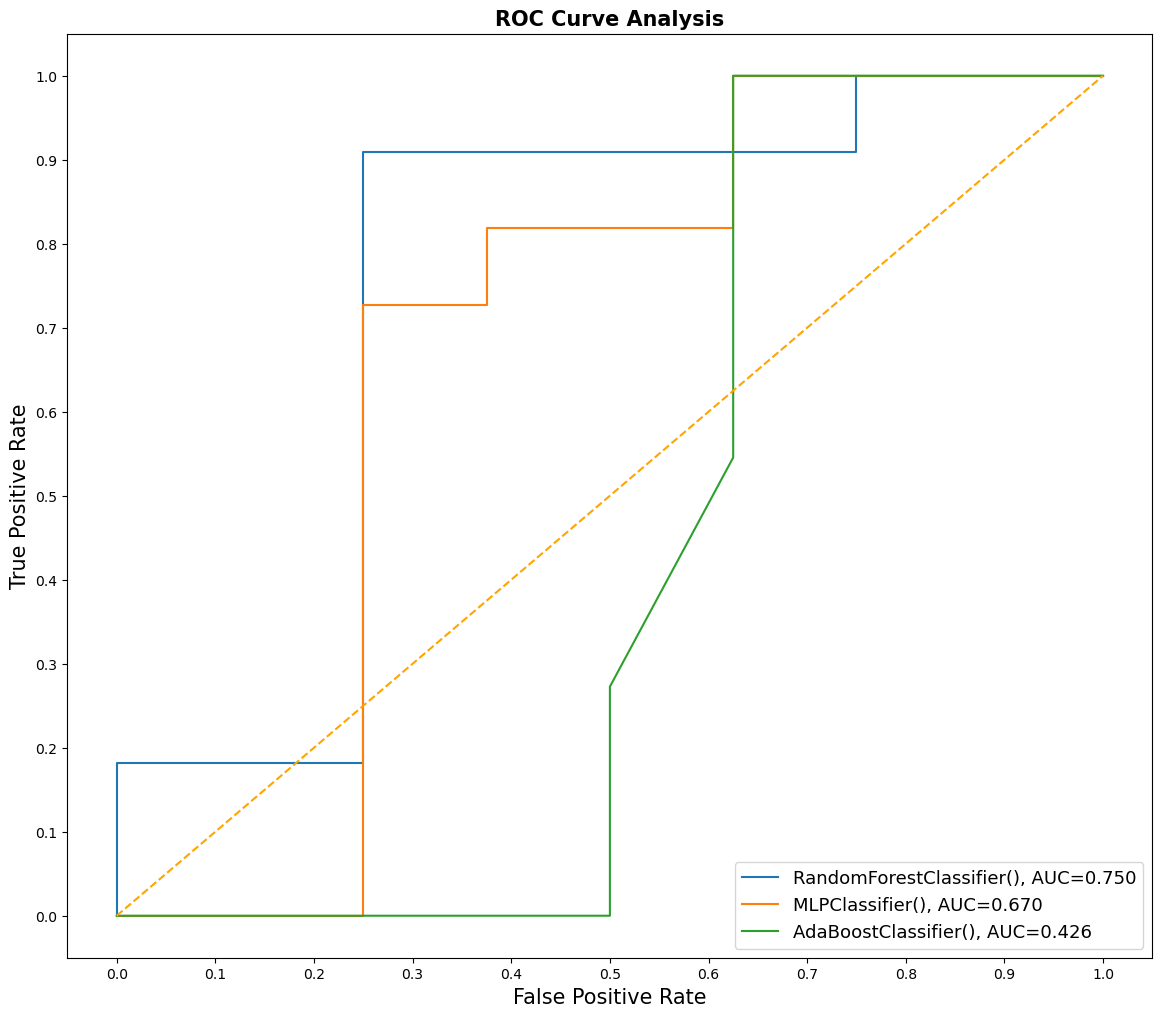

In [14]:
from sklearn import metrics

fitted = [rf_tuned, nnet_tuned, ada_tuned]

result_table = pd.DataFrame(columns=['classifier_name', 'fpr','tpr','auc', 
                                     'log_loss', 'clf_report'])

for clf in fitted:
    print(clf.estimator)
    yproba = clf.predict_proba(test[pred_vars])
    yclass = clf.predict(test[pred_vars])
    
    # auc information
    """
    Note that I specified the positve case here as 'truth'
    since that is what we are trying to detect. Otherwise,
    this line will present an error, since the classes are not
    0 or 1, but categorical labels.
    """
    fpr, tpr, _ = metrics.roc_curve(test[outcome],  yproba[:,1], pos_label='truth')
    auc = metrics.roc_auc_score(test[outcome], yproba[:,1])
    
    # log loss
    log_loss = metrics.log_loss(test[outcome], yproba[:,1])
    
    # add some other stats based on confusion matrix
    clf_report = metrics.classification_report(test[outcome], yclass)
    
    
    result_table = result_table.append({'classifier_name':str(clf.estimator),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'log_loss': log_loss,
                                        'clf_report': clf_report}, ignore_index=True)
    


result_table.set_index('classifier_name', inplace=True)
# print(result_table)



fig = plt.figure(figsize=(14,12))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()


### 3b. Confusion Matrix Stats

In [15]:
for i in result_table.index:
    print('\n---- statistics for', i, "----\n")
    print(result_table.loc[i, 'clf_report'])
    print("Model log loss:", result_table.loc[i, 'log_loss'])


---- statistics for RandomForestClassifier() ----

              precision    recall  f1-score   support

         lie       0.60      0.75      0.67         8
       truth       0.78      0.64      0.70        11

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.69        19

Model log loss: 0.6041217476842522

---- statistics for MLPClassifier() ----

              precision    recall  f1-score   support

         lie       0.00      0.00      0.00         8
       truth       0.58      1.00      0.73        11

    accuracy                           0.58        19
   macro avg       0.29      0.50      0.37        19
weighted avg       0.34      0.58      0.42        19

Model log loss: 1.3175830953192744

---- statistics for AdaBoostClassifier() ----

              precision    recall  f1-score   support

         lie       0.43      0.38      0.40         8
       truth       0.58 

# Exercises
1. Name at least three limitations of this data.
2. From the results above, which model would you say performed best?

## Optional Exercises
3. With text analysis, the variables that you can construct are only limited by your imagination.
   Try computing another measure and see if that improves the prediction results.
   For example, you might try to count the number of times a transcription contains the use of "I".
4. Try cross-validation with the Leave-One-Out Method (like the paper). The sklearn 
   [leave-one-out](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html)
   function should be useful. You would not need a hold-out set for this, just report the average accuracy and
   score range.